#Ventilator

In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [3]:
path = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

# 간단 EDA

- id: globally-unique time step identifier across an entire file **전체 번호**
- breath_id: globally-unique time step for breaths **각 환자 번호**
- R: lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow. **기도가 얼마나 막혔는지(음료를 빨대로 마실 때 빨대를 조였다 폈다하는 것과 같다) 흐름 변화당 압력 변화 ~ 높은 R일수록 불기 어렵다**
- C: lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow. **폐의 순응력(같은 부피라도 풍선에 재질에 따라 쉽게 불러지는 것이 있고 어려운 것이 있다) 압력 변화당 부피 변화 ~ 높은 C 일수록 쉽게 불러진다**
- time_step: the actual time stamp. **각 환자의 타임스텝**
- u_in: the control input for the inspiratory solenoid valve. Ranges from 0 to 100. **inspiratory solenoid valve 흡기 벨브(?) [0.100]**
- u_out: the control input for the exploratory solenoid valve. Either 0 or 1. **exploratory solenoid valve 예비 벨브(?) 0 or 1**
- pressure: the airway pressure measured in the respiratory circuit, measured in cmH2O. **공기압(Target)**

In [ ]:
print(train.shape)
train.tail()

(6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938
6035999,6036000,125749,50,10,2.638017,1.482739,1,3.869032


In [ ]:
print(test.shape)
test.head()

(4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [ ]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [ ]:
train['R'].unique()

array([20, 50,  5])

In [ ]:
train['C'].unique()

array([50, 20, 10])

breath_id 당 개수 확인

A: 모두 80개씩

In [ ]:
print('breath_id 개수 :', len(train['breath_id'].unique()))
print('breath_id 당 개수 :', train['breath_id'].value_counts().unique())

breath_id 개수 : 75450
breath_id 당 개수 : [80]


In [ ]:
train[train['breath_id'] == 8] ## 일부는 test에 있다.

,id,breath_id,R,C,time_step,u_in,u_out,pressure


#Data Preprocessing

## Train

u_in을 범위로 나누기

0, 4, 8, 12, ..., 100으로 4씩 증가

In [ ]:
"""
t = 4
for i in range(0, 100+1, t):
    if i != 0:
        train['u_in_' + str(i)] = (train['u_in'] <= i).astype(int)
        train['u_in_' + str(i)] += train['u_in_' + str(i-t)]
    else:
        train.loc[:, 'u_in_' + str(i)] = (train['u_in'] <= i).astype(int)

for i in range(0, 100+1, t):
    train['u_in_' + str(i)] = train['u_in_' + str(i)] == 1

train = train.drop(['u_in'], axis=1)

R과 C를 원핫 인코딩

In [4]:
train = pd.get_dummies(train, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
for r in R_col:
    for c in C_col:
        train.loc[:, r+'_'+c] = train[r]*train[c]

train = train.drop(R_col+C_col, axis=1)

del R_col
del C_col

timestep는 시각이므로 시간(전후 시각 차이)로 바꾸자

In [5]:
train_set = {}
target_set = {}
target_tmp = train['pressure']
train_tmp = train.drop(['id', 'breath_id', 'pressure'], axis=1)
train_tmp.loc[:, 'time'] = train_tmp['time_step'].diff()
# time을 standardization하자
mu = train_tmp['time'].mean()
std = train_tmp['time'].std()
train_tmp['time'] = (train_tmp['time'] - mu) / std
train_tmp = train_tmp.drop(['time_step'], axis=1)

sample_size = 80
total_train_sample_num = train.shape[0] // sample_size # 75450
total_test_sample_num = test.shape[0] // sample_size # 50300

for i in range(total_train_sample_num):
    train_set[i] = train_tmp.iloc[sample_size*i: sample_size*(i+1)]
    train_set[i].iloc[0, -1] = 0
    target_set[i] = target_tmp.iloc[sample_size*i: sample_size*(i+1)]

feature_num = train_set[1].shape[1]

del train
del train_tmp
del target_tmp

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [6]:
train_set[0]

,u_in,u_out,R5_C10,R5_C20,R5_C50,R20_C10,R20_C20,R20_C50,R50_C10,R50_C20,R50_C50,time
0,0.083334,0,0,0,0,0,0,1,0,0,0,0.000000
1,18.383041,0,0,0,0,0,0,1,0,0,0,0.114326
2,22.509278,0,0,0,0,0,0,1,0,0,0,0.115039
3,22.808822,0,0,0,0,0,0,1,0,0,0,0.115602
4,25.355850,0,0,0,0,0,0,1,0,0,0,0.116232
...,...,...,...,...,...,...,...,...,...,...,...,...
75,4.974474,1,0,0,0,0,0,1,0,0,0,0.115819
76,4.978481,1,0,0,0,0,0,1,0,0,0,0.116051
77,4.981847,1,0,0,0,0,0,1,0,0,0,0.115575
78,4.984683,1,0,0,0,0,0,1,0,0,0,0.115413


## Test

In [ ]:
t = 4
for i in range(0, 100+1, t):
    if i != 0:
        test['u_in_' + str(i)] = (test['u_in'] <= i).astype(int)
        test['u_in_' + str(i)] += test['u_in_' + str(i-t)]
    else:
        test.loc[:, 'u_in_' + str(i)] = (test['u_in'] <= i).astype(int)

for i in range(0, 100+1, t):
    test['u_in_' + str(i)] = test['u_in_' + str(i)] == 1

test = test.drop(['u_in'], axis=1)

In [ ]:
test = pd.get_dummies(test, columns=['R', 'C'], prefix=['R', 'C'], prefix_sep='')
R_col = ['R5', 'R20', 'R50']
C_col = ['C10', 'C20', 'C50']
for r in R_col:
    for c in C_col:
        test.loc[:, r+'_'+c] = test[r]*test[c]

test = test.drop(R_col+C_col, axis=1)

del R_col
del C_col

In [ ]:
test_set = {}
test_tmp = test.drop(['id', 'breath_id'], axis=1)
test_tmp.loc[:, 'time'] = test_tmp['time_step'].diff()
test_tmp = test_tmp.drop(['time_step'], axis=1)

test_tmp['time'] = (test_tmp['time'] - mu) / std

for i in range(total_test_sample_num):
    test_set[i] = test_tmp.iloc[sample_size*i: sample_size*(i+1)]
    test_set[i].iloc[0, -1] = 0

del test
del test_tmp

## dataframe을 numpy로

In [7]:
X_train = np.zeros((total_train_sample_num, sample_size, feature_num))
y_train = np.zeros((total_train_sample_num, sample_size))
for i in range(total_train_sample_num):
    X_train[i, :, :] = train_set[i].to_numpy().astype(float)
    y_train[i, :] = np.array(target_set[i])

del train_set
del target_set

print(X_train.shape)
print(y_train.shape)

(75450, 80, 12)
(75450, 80)


In [ ]:
X_test = np.zeros((total_test_sample_num, sample_size, feature_num))
for i in range(total_test_sample_num):
    X_test[i, :, :] = test_set[i].to_numpy().astype(float)

del test_set

X_test.shape

# Build Model

1. **Transformer + Reinforcment Learning**

: Transformer를 Reinforcement Learning의 Q-Net 혹은 타겟 Q-Net에 적용

**보류**

2. Transformer 내 예측을 전체와 부분으로 나누기

In [8]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, MultiHeadAttention, Dropout, LayerNormalization
# from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2
from tensorflow.keras.layers import GRU, Bidirectional, Reshape, Flatten, LSTM
from tensorflow.keras.regularizers import L2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

from sklearn.model_selection import train_test_split, KFold

In [9]:
"""
filters=3
kernel_size_encoding=(3,1) #(1,5)
kernel_size_decoding=(3,1)
pool_size=(3,1) #(1,3)
"""

num_heads=sample_size # 80
embedding_dim=1
num_layers=2

l2_rate=0 #0.01
dropout_rate=0 #0.01
layernorm_eps=1e-6

learning_rate=0.01
minibatch_size=14
num_epochs=2

learning_rate_kFold = 0.01
minibatch_size_kFold=4096
num_epochs_kFold = 100

learning_rate_stacking = 0.0001
minibatch_size_stacking = 4096*2
num_epochs_stacking = 100000

In [10]:
class Layer(tf.keras.Model):
    def __init__(self, num_heads=80, embedding_dim=12, layernorm_eps=1e-6):
        super(Layer, self).__init__()

        self.lstm1 = Bidirectional(LSTM(6, return_sequences=True))
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)

        self.lstm2 = Bidirectional(LSTM(6, return_sequences=True))
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=1)

        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.ffn1 = Dense(40, activation='relu')
        self.ffn2 = Dense(80)
    
    def call(self, input): #(1, 80, 12)
        print(input.shape)
        y1_1 = self.lstm1(input)
        print(y1_1.shape)
        y1_2 = self.mha1(input[:, :, :, np.newaxis], input[:, :, :, np.newaxis], input[:, :, :, np.newaxis]) 
        print(y1_2.shape)

        y1 = self.layernorm1(input[:, :, :, np.newaxis] + y1_1[:, :, :, np.newaxis] + y1_2)
        print(y1.shape)

        y2_1 = self.lstm2(tf.reshape(y1, [y1.shape[0], y1.shape[1], -1]))
        print(y2_1.shape)
        y2_2 = self.mha2(y1, y1, y1)
        print(y2_2.shape)

        y2 = self.layernorm2(y2_1 + tf.reshape(y2_2, [y2_2.shape[0], y2_2.shape[1], -1]))
        print(y2.shape)
        y3 = self.ffn1(y2)
        print(y3.shape)
        y4 = self.ffn2(y3)
        print(y4.shape)
        return y4

In [ ]:
model = Layer()
model.compile(optimizer=Adam(0.01), loss='mean_absolute_error', metrics='mean_absolute_error')
model.build((1, 80, 12))
model.summary()

(1, 80, 12)
(1, 80, 12)
(1, 80, 12, 1)
(1, 80, 12, 1)
(1, 80, 12)
(1, 80, 12, 1)
(1, 80, 12)
(1, 80, 40)
(1, 80, 80)
Model: "layer_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_40 (Bidirectio multiple                  912       
_________________________________________________________________
multi_head_attention_68 (Mul multiple                  6721      
_________________________________________________________________
layer_normalization_39 (Laye multiple                  2         
_________________________________________________________________
bidirectional_41 (Bidirectio multiple                  912       
_________________________________________________________________
multi_head_attention_69 (Mul multiple                  561       
_________________________________________________________________
layer_normalization_40 (Laye multiple                  24        
_______

In [ ]:
X = X_train
y = y_train
del X_train
del y_train

In [ ]:
kFold = KFold(n_splits=10, shuffle=True, random_state=21)

history = {}
fold_num = 0
for train_idx, valid_idx in kFold.split(X):
    fold_num += 1
    print("KFold", fold_num)
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    model = Layer()
    model.compile(optimizer=Adam(0.01), loss='mean_absolute_error', metrics='mean_absolute_error')

    history[str(fold_num)] = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_valid, y_valid), verbose=2)

KFold 1
Epoch 1/50
(None, 80, 12)
(None, 80, 12)
(None, 80, 12, 1)
(None, 80, 12, 1)


TypeError: ignored

## Transformer Model

In [ ]:
def FeedForward(l2_rate=0.01): # filters=3, kernel_size=(3,5), 
    return tf.keras.Sequential([
                                #ZeroPadding2D((1,0)),
                                #Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(l2_rate)),
                                #Conv2D(filters=1, kernel_size=1, strides=1, activation='relu', kernel_regularizer=L2(l2_rate)),
                                Reshape((80, -1)),
                                Bidirectional(GRU(1, return_sequences=True)),
                                Bidirectional(GRU(1, return_sequences=True)),
                                Flatten(),
                                Dense(256, activation='relu'),
                                Dense(80)
                                ])

###Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, 
                 l2_rate=0.01, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), pool_size=(3,1), 

        super(EncoderLayer, self).__init__()

        self.gru = GRU(1, return_sequences=True)

        #self.zeropad = ZeroPadding2D((1,0))
        #self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(l2_rate))
        #self.conv2 = Conv2D(filters=1, kernel_size=1, strides=1, activation='relu', kernel_regularizer=L2(l2_rate))

        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.ffn = FeedForward(l2_rate=l2_rate) # filters=filters, kernel_size=kernel_size,

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, training=True): # mask,

        #if input.ndim == 4:
        #    input = tf.reshape(input, [input.shape[0], input.shape[1], -1])
        y_1 = self.gru(input)

        #if y_1.ndim == 3:
        #    y_1 = y_1[:,:,:, np.newaxis]
        #y_2 = self.zeropad(y_1)
        #y_2 = self.conv1(y_2) 
        #y_2 = self.conv2(y_2) 
        out_2 = self.layernorm1(input + y_1)# + y_2) 

        y_3 = self.mha(out_2, out_2, out_2, training=training) # mask, 
        out_3 = self.layernorm2(y_3 + out_2)
        y_4 = self.ffn(out_3)
        y_4 =  self.dropout(y_4) 
        out_4 = self.layernorm3(y_4[:,:, np.newaxis] + out_3)

        return out_4
    

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, num_layers=3, 
                 l2_rate=0.01, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), pool_size=(3,1), 
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(num_heads=num_heads, embedding_dim=embedding_dim, 
                                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) # filters=filters, kernel_size=kernel_size, pool_size=pool_size, 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, input, training=True):

        #mask = create_padding_mask(input)

        input *= np.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))
        y = self.dropout(input)
        
        for i in range(self.num_layers):
            y = self.enc_layers[i](y, training) #, mask)

        return y

###Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), 
        super(DecoderLayer, self).__init__()

        self.gru = GRU(1, return_sequences=True)
        
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.ffn = FeedForward(l2_rate=l2_rate) # filters=filters, kernel_size=kernel_size, 

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, enc_output, training=True): # look_ahead_mask, padding_mask, 

        #input = input[:,:, np.newaxis]
        if input.ndim == 4:
            input = tf.reshape(input, [input.shape[0], input.shape[1], -1])
        y_1 = self.gru(input)
        
        if y_1.ndim == 3:
            y_1 = y_1[:,:,:, np.newaxis]
        if input.ndim == 3:
            input = input[:,:,:, np.newaxis]
        # BLOCK 1
        y_2 = self.mha1(y_1, y_1, y_1, training=training) # look_ahead_mask,
        Q = self.layernorm1(y_2 + y_1 + input)
        
        if enc_output.ndim == 3:
            enc_output = enc_output[:, :, :, np.newaxis]
        # BLOCK 2
        y_3 = self.mha2(Q, enc_output, enc_output, training=training) # padding_mask, 
        y_3 = self.layernorm2(y_3 + Q)
        
        #BLOCK 3
        y_4 = self.ffn(y_3)  
        y_4 = self.dropout(y_4)
        y_4 = self.layernorm3(y_4[:,:, np.newaxis, np.newaxis] + y_3)

        return y_4

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, num_layers=3, dropout_rate=0.1, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), 
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.dec_layers = [DecoderLayer(num_heads=num_heads, embedding_dim=embedding_dim, # filters=filters, kernel_size=kernel_size,
                                        dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, enc_output, training=True):

        # padding_mask = create_padding_mask(input)
        # look_ahead_mask = create_look_ahead_mask(80) ##?
        
        input *= np.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))
        y = self.dropout(input)

        for i in range(self.num_layers):
            y = self.dec_layers[i](y, enc_output, training) # look_ahead_mask, padding_mask
        
        return y

###Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, # filters=3, kernel_size_encoding=(3, 1), kernel_size_decoding=(3,1), pool_size=(3, 1), 
                 num_heads=80, embedding_dim=1, num_layers=3, 
                 l2_rate=0.01, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                               l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) # filters=filters, kernel_size=kernel_size_encoding, pool_size=pool_size, 

        self.decoder = Decoder(num_heads=num_heads, embedding_dim=embedding_dim, # filters=filters, kernel_size=kernel_size_decoding,
                               num_layers=num_layers, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)

        self.flatten = Flatten()
        self.ffn = Dense(num_heads)
    
    def call(self, input, target, training=True):

        enc_output = self.encoder(input, training)
        dec_output = self.decoder(target, enc_output, training)
        
        final_output = self.flatten(dec_output)
        final_output = self.ffn(final_output)
        
        return final_output

## K Fold

In [ ]:
# K-Fold CV를 위한 모델
def FeedForward_KFold():
    return tf.keras.Sequential([
                                Bidirectional(GRU(37, return_sequences=True)),
                                Bidirectional(GRU(37, return_sequences=True)),
                                Bidirectional(GRU(1, return_sequences=True)),
                                Flatten(),
                                Dense(256, activation='relu'),
                                Dense(128, activation='relu'),
                                Dense(80)
                                ])

In [ ]:
m = FeedForward_KFold()
m.build((1, 80, 12))
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_25 (Bidirectio (1, 80, 74)               11322     
_________________________________________________________________
bidirectional_26 (Bidirectio (1, 80, 74)               25086     
_________________________________________________________________
bidirectional_27 (Bidirectio (1, 80, 2)                462       
_________________________________________________________________
flatten_1 (Flatten)          (1, 160)                  0         
_________________________________________________________________
dense_56 (Dense)             (1, 256)                  41216     
_________________________________________________________________
dense_57 (Dense)             (1, 128)                  32896     
_________________________________________________________________
dense_58 (Dense)             (1, 80)                  

## Stacking

### Small stacking

In [ ]:
def FeedForward_Stacking():
    return tf.keras.Sequential([
                                #Bidirectional(LSTM(36, return_sequences=True)),
                                #Bidirectional(LSTM(36, return_sequences=True)),
                                #Bidirectional(GRU(1, return_sequences=True)),
                                LSTM(1, return_sequences=True),
                                Flatten(),
                                #Dense(160, activation='relu'),
                                #Dense(800, activation='relu'),
                                #Dense(15, activation='relu'),
                                Dense(80)
                                ])

### Big Stacking

In [ ]:
def FeedForward_Stacking():
    return tf.keras.Sequential([
                                Bidirectional(GRU(6, return_sequences=True)),
                                Bidirectional(GRU(1, return_sequences=True)),
                                Flatten(),
                                Dense(80, activation='relu'),
                                Dense(40, activation='relu'),
                                Dense(80)
                                ])

In [ ]:
class Layer_Stacking(tf.keras.layers.Layer):
    def __init__(self, num_heads=80, embedding_dim=1, dropout_rate=0, layernorm_eps=1e-6): # filters=3, kernel_size=(3,1), 
        super(Layer_Stacking, self).__init__()

        self.gru = GRU(1, return_sequences=True)
        
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate, kernel_regularizer=L2(l2_rate))

        self.ffn = FeedForward_Stacking() # filters=filters, kernel_size=kernel_size, 

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout = Dropout(dropout_rate)
    
    def call(self, input, enc_output, training=True):

        if input.ndim == 4:
            input = tf.reshape(input, [input.shape[0], input.shape[1], -1])
        # BLOCK 0
        y_1 = self.gru(input)        

        if y_1.ndim == 3:
            y_1 = y_1[:,:,:, np.newaxis]
        if input.ndim == 3:
            input = input[:,:,:, np.newaxis]
        # BLOCK 1
        y_2 = self.mha1(y_1, y_1, y_1, training=training)
        Q = self.layernorm1(y_2 + y_1 + input)
        
        if enc_output.ndim == 3:
            enc_output = enc_output[:, :, :, np.newaxis]
        # BLOCK 2
        y_3 = self.mha2(Q, enc_output, enc_output, training=training)
        y_3 = self.layernorm2(y_3 + Q)
        
        #BLOCK 3
        y_4 = self.ffn(y_3)  
        y_4 = self.dropout(y_4)
        y_4 = self.layernorm3(y_4[:,:, np.newaxis, np.newaxis] + y_3)

        return y_4

In [ ]:
class Stacking(tf.keras.Model):
    def __init__(self, num_heads=80, embedding_dim=1, num_layers=2, dropout_rate=0, layernorm_eps=1e-6):
        super(Stacking, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.dec_layers = [DecoderLayer(num_heads=num_heads, embedding_dim=embedding_dim, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)

        self.flatten = Flatten()
        self.ffn = Dense(num_heads)
    
    def call(self, input, enc_output, training=True):
        
        input *= np.sqrt(tf.cast(self.embedding_dim, dtype=tf.float32))
        y = self.dropout(input)

        for i in range(self.num_layers):
            y = self.dec_layers[i](y, enc_output, training)
        
        final_output = self.flatten(y)
        final_output = self.ffn(final_output)

        return final_output

#Training

## training functions

### training function

In [ ]:
def call_Model(num_heads, embedding_dim, num_layers, 
                        l2_rate, dropout_rate, layernorm_eps, learning_rate):
    tf.keras.backend.clear_session()

    Model = Transformer(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_mid/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    optimizer = Adam(learning_rate)
    compute_cost = MeanAbsoluteError()
    
    return Model, optimizer, compute_cost

In [ ]:
def train_one_step(X_train, y_train, Model, optimizer, compute_cost, training=True):

  with tf.GradientTape() as tape:
      # 1. Predict
      y_hat = Model(X_train, y_train[:,:, np.newaxis])
      
      # 2. Compute cost
      cost = compute_cost(y_hat, y_train)
  
  if (training==True):
      grads = tape.gradient(cost, Model.trainable_variables)
      optimizer.apply_gradients(zip(grads, Model.trainable_variables))  

  return y_hat, cost

In [ ]:
def train_model(X, y, Model, optimizer, compute_cost, minibatch_size=12, num_epochs=100, print_cost=True,
                num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate):

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)

    #numpy를 tensorflow dataset으로
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    del X_train
    del y_train
    del X_valid
    del y_valid

    train_minibatches = train_set.batch(minibatch_size).prefetch(8)
    valid_minibatches = valid_set.batch(minibatch_size).prefetch(8)
    del train_set

    train_costs = []
    valid_costs = []

    for epoch in range(1, num_epochs+1):
        
        # Training
        epoch_cost = 0.
        i = 0
        m = 0
        print("learning rate =", learning_rate)
        for (minibatch_X, minibatch_y) in train_minibatches:
            _ , minibatch_cost = train_one_step(minibatch_X, minibatch_y, Model, optimizer, compute_cost)
            epoch_cost += minibatch_cost

            m += 1
            i += 1
            if i % 100 == 0:
                print('>', end=' ')
                path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_mid/'
                Model.save_weights(path_weights + 'weights')
                if i % 1000 == 0:
                  print("%dth minibatch_cost %f" %(i, minibatch_cost))
            elif i % 50 == 0:
                print('\'', end='')
            elif i % 10 == 0:
                print(".", end='')

        epoch_cost /= m
        path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_mid/'
        Model.save_weights(path_weights + 'weights')

        # Validating
        n = 0
        valid_cost = 0.         
        for (minibatch_X, minibatch_y) in valid_minibatches:
            _ , minibatch_cost = train_one_step(minibatch_X, minibatch_y, Model, optimizer, compute_cost, training=False)
            valid_cost += minibatch_cost
            n += 1
        valid_cost /= n

        train_costs.append(epoch_cost)
        valid_costs.append(valid_cost)
        
        # Print Cost
        if print_cost == True:
            print("After epoch %i : Train Cost %f" % (epoch, epoch_cost), end=" ")
            print("Valid Cost %f" % (valid_cost))
        
        # Tuning Learning Rate
        """
        if len(train_costs) >= 2 and train_costs[-1] > train_costs[-2]:
          if len(train_costs) >= 3 and train_costs[-1] > train_costs[-3]:
            print("Down learning rate ( /=10 )")
            learning_rate /= 10
          else:
            print("Down learning rate ( /=2 )")
            learning_rate /=2
        """
        
        learning_rate = learning_rate * 0.8
        
        """
        if learning_rate == 0.0002:
            learning_rate = 0.0001
        elif learning_rate == 0.0001:
            learning_rate = 0.0002
        """
        
        Model, optimizer, compute_cost = call_Model(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate)

    return train_costs, valid_costs

###K-Fold Training

In [ ]:
def call_kFoldModel(fold_num, learning_rate):
    tf.keras.backend.clear_session()

    Model = FeedForward_KFold()
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_kFold/' + fold_num + '/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [ ]:
def save_weights_kFold(Model, fold_num):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_kFold/' + fold_num + '/'
    Model.save_weights(path_weights + 'weights')

In [ ]:
def training_kFold(X, y, learning_rate, minibatch_size, num_epochs):
    kFold = KFold(n_splits=20, shuffle=True, random_state=21)

    history = {}
    fold_num = 0
    for train_idx, valid_idx in kFold.split(X):
        fold_num += 1
        print("KFold", fold_num)
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        Model_kFold = call_kFoldModel( str(fold_num), learning_rate)

        history[str(fold_num)] = Model_kFold.fit(X_train, y_train, batch_size=minibatch_size, epochs=num_epochs, validation_data=(X_valid, y_valid), verbose=2)

        save_weights_kFold(Model_kFold, str(fold_num))
    
    return history

### Stacking

#### stack

In [ ]:
def stack_one_step(X, num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate_Model=learning_rate,
                   learning_rate=learning_rate_kFold, minibatch_size=minibatch_size, minibatch_size_kFold=minibatch_size_kFold):
    Model, _, _ = call_Model(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate_Model)
    kFold1 = call_kFoldModel( '1', learning_rate=learning_rate_kFold)
    kFold2 = call_kFoldModel( '2', learning_rate=learning_rate_kFold)
    kFold3 = call_kFoldModel( '3', learning_rate=learning_rate_kFold)
    kFold4 = call_kFoldModel( '4', learning_rate=learning_rate_kFold)
    kFold5 = call_kFoldModel( '5', learning_rate=learning_rate_kFold)
    
    input_train = tf.data.Dataset.from_tensor_slices((X))
    train_minibatches = input_train.batch(minibatch_size).prefetch(8)

    prediction = np.zeros((1, 80))

    i = 0
    for minibatch_X in train_minibatches:
        target_pred = np.zeros((minibatch_X.shape[0], 80, 1))
        #target_pred = np.ones((minibatch_X.shape[0], 80, 1))
        pred = Model(minibatch_X, target_pred, training=False)
        prediction = np.concatenate((prediction, pred))

        i += 1
        if i % 100 == 0:
            print('>', end=' ')
            if i % 1000 == 0:
              print(i, prediction.shape)
        elif i % 50 == 0:
            print('\'', end='')
        elif i % 10 == 0:
            print(".", end='')
    
    Model_pred = prediction[1:, :]
    print(Model_pred.shape)
    kFold1_pred = kFold1.predict(X, batch_size=minibatch_size_kFold)
    print(kFold1_pred.shape)
    kFold2_pred = kFold2.predict(X, batch_size=minibatch_size_kFold)
    print(kFold2_pred.shape)
    kFold3_pred = kFold3.predict(X, batch_size=minibatch_size_kFold)
    print(kFold3_pred.shape)
    kFold4_pred = kFold4.predict(X, batch_size=minibatch_size_kFold)
    print(kFold4_pred.shape)
    kFold5_pred = kFold5.predict(X, batch_size=minibatch_size_kFold)
    print(kFold5_pred.shape)

    X_stack = np.stack((Model_pred, kFold1_pred, kFold2_pred, kFold3_pred, kFold4_pred, kFold5_pred), axis=2)
    print(X_stack.shape)
    
    return X_stack

#### Stack small

In [ ]:
def call_stackingModel_small(learning_rate):
    tf.keras.backend.clear_session()

    Model = FeedForward_Stacking()
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_small_small/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [ ]:
def save_weights_stacking_small(Model):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_small_small/'
    Model.save_weights(path_weights + 'weights')

In [ ]:
def training_stacking(X, y, learning_rate, minibatch_size, num_epochs):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)

    Model_stacking = call_stackingModel_small(learning_rate)

    history = Model_stacking.fit(X_train, y_train, batch_size=minibatch_size, epochs=num_epochs, validation_data=(X_valid, y_valid))
    
    save_weights_stacking_small(Model_stacking)
    
    return history

#### Stack_Decoder

In [ ]:
def call_stackingModel(learning_rate):
    tf.keras.backend.clear_session()

    Model = Stacking(num_heads=80, embedding_dim=1, num_layers=2, dropout_rate=0, layernorm_eps=1e-6)
      
    Model.compile(optimizer=Adam(learning_rate), loss='mean_absolute_error', metrics='mean_absolute_error')

    # weights load
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_new/'

    if os.path.isdir(path_weights):
        Model.load_weights(path_weights + 'weights')
    
    return Model

In [ ]:
def save_weights_stacking(Model):
    path_weights = '/content/drive/MyDrive/Ventilator_Pressure_Prediction/weights_stacking_new/'
    Model.save_weights(path_weights + 'weights')

In [ ]:
def training_stacking(X, y, learning_rate, minibatch_size, num_epochs, print_cost = True):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)
    
    #numpy를 tensorflow dataset으로
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    del X_train
    del y_train
    del X_valid
    del y_valid

    train_minibatches = train_set.batch(minibatch_size).prefetch(8)
    valid_minibatches = valid_set.batch(minibatch_size).prefetch(8)
    del train_set

    train_costs = []
    valid_costs = []

    Model_stacking = call_stackingModel(learning_rate)
    optimizer = Adam(learning_rate)
    compute_cost = MeanAbsoluteError()

    #history = Model_stacking.fit(X_train, y_train, batch_size=minibatch_size, epochs=num_epochs, validation_data=(X_valid, y_valid)) 
    for epoch in range(1, num_epochs+1):
        
        # Training
        m = 0.
        epoch_cost = 0.
        i = 0
        print("learning rate =", learning_rate)
        for (minibatch_X, minibatch_y) in train_minibatches:
            _ , minibatch_cost = train_one_step(minibatch_X, minibatch_y, Model_stacking, optimizer, compute_cost)
            epoch_cost += minibatch_cost
            m += 1
            i += 1
            if i % 100 == 0:
                print('>', end=' ')
                save_weights_stacking(Model_stacking)
                if i % 1000 == 0:
                  print("%dth minibatch_cost %f" %(i, minibatch_cost))
            elif i % 50 == 0:
                print('\'', end='')
            elif i % 10 == 0:
                print(".", end='')

        epoch_cost /= m
        save_weights_stacking(Model_stacking)

        # Validating
        n = 0.
        valid_cost = 0.
        for (minibatch_X, minibatch_y) in valid_minibatches:
            _ , minibatch_cost = train_one_step(minibatch_X, minibatch_y, Model_stacking, optimizer, compute_cost, training=False)
            valid_cost += minibatch_cost
            n += 1
        
        valid_cost /= n

        train_costs.append(epoch_cost)
        valid_costs.append(valid_cost)
        
        # Print Cost
        if print_cost == True:
            print("After epoch %i : Train Cost %f" % (epoch, epoch_cost), end=" ")
            print("Valid Cost %f" % (valid_cost))
        
        # Tuning Learning Rate
    
    return train_costs, valid_costs #history

##train

###train

In [ ]:
Model, optimizer, compute_cost = call_Model(num_heads=num_heads, embedding_dim=embedding_dim, num_layers=num_layers, 
                        l2_rate=l2_rate, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps, learning_rate=learning_rate)

In [ ]:
train_costs, valid_costs = train_model(X_train, y_train, Model, optimizer, compute_cost, minibatch_size=minibatch_size, num_epochs=num_epochs)

learning rate = 0.001
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 1000th minibatch_cost 3.145919
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 2000th minibatch_cost 2.711488
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 3000th minibatch_cost 3.360234
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 4000th minibatch_cost 2.834693
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'After epoch 1 : Train Cost 3.067055 Valid Cost 3.074375
learning rate = 0.0008
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 1000th minibatch_cost 3.146111
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ..

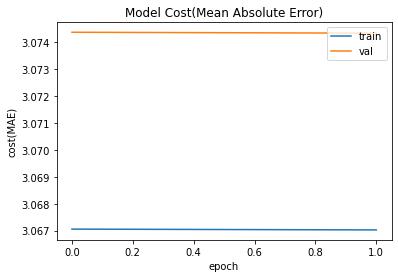

In [ ]:
plt.plot(train_costs)
plt.plot(valid_costs)
plt.title('Model Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
Model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  149010    
_________________________________________________________________
decoder (Decoder)            multiple                  125940    
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  6480      
Total params: 281,430
Trainable params: 281,430
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
learning rate = 0.08 
After epoch 1 : Train Cost 0.220521 Valid Cost 0.223896
After epoch 2 : Train Cost 0.220325 Valid Cost 0.220182
learning rate = 0.08
After epoch 1 : Train Cost 0.220438 Valid Cost 0.220495
learning rate = 0.08*0.8
After epoch 2 : Train Cost 0.220148 Valid Cost 0.219917
learning rate = 0.08*0.8**2
After epoch 3 : Train Cost 0.219866 Valid Cost 0.219927
learning rate = 0.05
After epoch 1 : Train Cost 0.219876 Valid Cost 0.219855
learning rate = 0.05 * 0.8
After epoch 2 : Train Cost 0.219680 Valid Cost 0.219868
learning rate = 0.05 * 0.8**2
After epoch 3 : Train Cost 0.219582 Valid Cost 0.219757
learning rate = 0.05
After epoch 1 : Train Cost 0.219854 Valid Cost 0.219851
learning rate = 0.04
After epoch 2 : Train Cost 0.219686 Valid Cost 0.219809
learning rate = 0.032
After epoch 3 : Train Cost 0.219539 Valid Cost 0.219782
learning rate = 0.04
After epoch 1 : Train Cost 0.219681 Valid Cost 0.219800
learning rate = 0.032
After epoch 2 : Train Cost 0.219544 Valid Cost 0.219814
learning rate = 0.0256
learning rate = 0.03
After epoch 1 : Train Cost 0.219531 Valid Cost 0.219898
learning rate = 0.024
After epoch 2 : Train Cost 0.219437 Valid Cost 0.219749
learning rate = 0.0192
After epoch 3 : Train Cost 0.219352 Valid Cost 0.219738
learning rate = 0.01536
After epoch 4 : Train Cost 0.219285 Valid Cost 0.219739
learning rate = 0.012288
After epoch 5 : Train Cost 0.219240 Valid Cost 0.219731
learning rate = 0.0098
After epoch 6 : Train Cost 0.219216 Valid Cost 0.219685
learning rate = 0.01
After epoch 1 : Train Cost 0.219221 Valid Cost 0.219693
learning rate = 0.008
After epoch 2 : Train Cost 0.219192 Valid Cost 0.219687
learning rate = 0.0064
After epoch 3 : Train Cost 0.219166 Valid Cost 0.219669
learning rate = 0.03
After epoch 1 : Train Cost 0.219523 Valid Cost 0.219750
learning rate = 0.024
After epoch 2 : Train Cost 0.219391 Valid Cost 0.219817
learning rate = 0.0192
After epoch 3 : Train Cost 0.219336 Valid Cost 0.219867
learning rate = 0.03
After epoch 1 : Train Cost 0.219377 Valid Cost 0.219736
learning rate = 0.024
After epoch 2 : Train Cost 0.219415 Valid Cost 0.219743
learning rate = 0.0192
After epoch 3 : Train Cost 0.219347 Valid Cost 0.219740
learning rate = 0.02
After epoch 1 : Train Cost 0.219368 Valid Cost 0.219800
learning rate = 0.016
After epoch 2 : Train Cost 0.219279 Valid Cost 0.219723
learning rate = 0.0128
After epoch 3 : Train Cost 0.219250 Valid Cost 0.219705
learning rate = 0.016
After epoch 1 : Train Cost 0.219299 Valid Cost 0.219719
learning rate = 0.0128
After epoch 2 : Train Cost 0.219257 Valid Cost 0.219710
learning rate = 0.01024
After epoch 3 : Train Cost 0.219225 Valid Cost 0.219687
learning rate = 0.01
After epoch 1 : Train Cost 0.219220 Valid Cost 0.219692
learning rate = 0.008
After epoch 2 : Train Cost 0.219185 Valid Cost 0.219690
learning rate = 0.0064
After epoch 3 : Train Cost 0.219167 Valid Cost 0.219673
learning rate = 0.006
After epoch 1 : Train Cost 0.219159 Valid Cost 0.219666
learning rate = 0.0048
After epoch 2 : Train Cost 0.219149 Valid Cost 0.219652
learning rate = 0.004
After epoch 1 : Train Cost 0.219138 Valid Cost 0.219638
learning rate = 0.0032
After epoch 2 : Train Cost 0.219128 Valid Cost 0.219630
learning rate = 0.00256
After epoch 3 : Train Cost 0.219122 Valid Cost 0.219621
learning rate = 0.002048
After epoch 4 : Train Cost 0.219115 Valid Cost 0.219616
learning rate = 0.0016384
After epoch 5 : Train Cost 0.219111 Valid Cost 0.219614
learning rate = 0.00131072
After epoch 6 : Train Cost 0.219107 Valid Cost 0.219612
learning rate = 0.001048576
After epoch 7 : Train Cost 0.219104 Valid Cost 0.219611
learning rate = 0.0008388608
After epoch 8 : Train Cost 0.219101 Valid Cost 0.219608

learning rate = 0.004
>> 1000th minibatch_cost 3.145652 >> 2000th minibatch_cost 2.714251 >> 3000th minibatch_cost 3.352606 >> 4000th minibatch_cost 2.834317
After epoch 1 : Train Cost 0.219138 Valid Cost 0.219639
learning rate = 0.0032
>> 1000th minibatch_cost 3.147006 >> 2000th minibatch_cost 2.711073 >> 3000th minibatch_cost 3.356500 >> 4000th minibatch_cost 2.833653
After epoch 2 : Train Cost 0.219128 Valid Cost 0.219629
learning rate = 0.00256
>> 1000th minibatch_cost 3.146948 >> 2000th minibatch_cost 2.710989 >> 3000th minibatch_cost 3.357997 >> 4000th minibatch_cost 2.833716
After epoch 3 : Train Cost 0.219121 Valid Cost 0.219621

learning rate = 0.003
>> 1000th minibatch_cost 3.146536 >> 2000th minibatch_cost 2.711569 >> 3000th minibatch_cost 3.358839 >> 4000th minibatch_cost 2.833517
After epoch 1 : Train Cost 0.219125 Valid Cost 0.219626
learning rate = 0.0024
>> 1000th minibatch_cost 3.146902 >> 2000th minibatch_cost 2.710838 >> 3000th minibatch_cost 3.358616 >> 4000th minibatch_cost 2.833969
After epoch 2 : Train Cost 0.219119 Valid Cost 0.219621
learning rate = 0.00192
>> 1000th minibatch_cost 3.146818 >> 2000th minibatch_cost 2.710620 >> 3000th minibatch_cost 3.359779 >> 4000th minibatch_cost 2.834016
After epoch 3 : Train Cost 0.219113 Valid Cost 0.219615

learning rate = 0.002
>> 1000th minibatch_cost 3.146647>> 2000th minibatch_cost 2.710645>> 3000th minibatch_cost 3.359598>> 4000th minibatch_cost 2.834101
After epoch 1 : Train Cost 0.219114 Valid Cost 0.219615
learning rate = 0.0016
>> 1000th minibatch_cost 3.146886>> 2000th minibatch_cost 2.710226>> 3000th minibatch_cost 3.360710>> 4000th minibatch_cost 2.834181
After epoch 2 : Train Cost 0.219110 Valid Cost 0.219612
learning rate = 0.00128
>> 1000th minibatch_cost 3.146775>> 2000th minibatch_cost 2.710151>> 3000th minibatch_cost 3.361622>> 4000th minibatch_cost 2.834335
After epoch 3 : Train Cost 0.219107 Valid Cost 0.219613

learnng rate = 0.001
>> 1000th minibatch_cost 3.146709 >> 2000th minibatch_cost 2.710370 >> 3000th minibatch_cost 3.362341 >> 4000th minibatch_cost 2.834107
After epoch 1 : Train Cost 0.219103 Valid Cost 0.219611
learning rate = 0.0008
>> 1000th minibatch_cost 3.146544 >> 2000th minibatch_cost 2.710596 >> 3000th minibatch_cost 3.362398 >> 4000th minibatch_cost 2.834036
After epoch 2 : Train Cost 0.219101 Valid Cost 0.219608
learning rate = 0.00064
>> 1000th minibatch_cost 3.146454 >> 2000th minibatch_cost 2.710769 >> 3000th minibatch_cost 3.362088 >> 4000th minibatch_cost 2.834307
After epoch 3 : Train Cost 0.219099 Valid Cost 0.219605

learning rate = 0.008>> 1000th minibatch_cost 3.144133>> 2000th minibatch_cost 2.718011>> 3000th minibatch_cost 3.348295>> 4000th minibatch_cost 2.836139
After epoch 1 : Train Cost 0.219193 Valid Cost 0.219678

there are some missing errors

>> 1000th minibatch_cost 3.146178>> 2000th minibatch_cost 2.713100>> 3000th minibatch_cost 3.356644>> 4000th minibatch_cost 2.833087
After epoch 1 : Train Cost 0.219099 Valid Cost 0.219616
learning rate = 0.00032
>> 1000th minibatch_cost 3.146639>> 2000th minibatch_cost 2.712078>> 3000th minibatch_cost 3.358139>> 4000th minibatch_cost 2.833200
After epoch 2 : Train Cost 0.219097 Valid Cost 0.219611
learning rate = 0.000256
>> 1000th minibatch_cost 3.146698 >> 2000th minibatch_cost 2.711536>> 3000th minibatch_cost 3.359316>> 4000th minibatch_cost 2.833331
After epoch 3 : Train Cost 0.219096 Valid Cost 0.219607
learning rate = 0.0002048
>> 1000th minibatch_cost 3.146657>> 2000th minibatch_cost 2.711291>> 3000th minibatch_cost 3.360166>> 4000th minibatch_cost 2.833515
After epoch 4 : Train Cost 0.219096 Valid Cost 0.219605
learning rate = 0.00016384
>> 1000th minibatch_cost 3.146586>> 2000th minibatch_cost 2.711208>> 3000th minibatch_cost 3.360779>> 4000th minibatch_cost 2.833689
After epoch 5 : Train Cost 0.219095 Valid Cost 0.219603
learning rate = 0.000131072
>> 1000th minibatch_cost 3.146488>> 2000th minibatch_cost 2.711277>> 3000th minibatch_cost 3.361251>> 4000th minibatch_cost 2.833840
After epoch 6 : Train Cost 0.219094 Valid Cost 0.219602
learning rate = 0.0001048576
>> 1000th minibatch_cost 3.146416>> 2000th minibatch_cost 2.711383>> 3000th minibatch_cost 3.361588>> 4000th minibatch_cost 2.833980
After epoch 7 : Train Cost 0.219094 Valid Cost 0.219602
learning rate = 8.388608000000005e-05
>> 1000th minibatch_cost 3.146367>> 2000th minibatch_cost 2.711462>> 3000th minibatch_cost 3.361859>> 4000th minibatch_cost 2.834099
After epoch 8 : Train Cost 0.219094 Valid Cost 0.219601
"""

'\nlearning rate = 0.08 \nAfter epoch 1 : Train Cost 0.220521 Valid Cost 0.223896\nAfter epoch 2 : Train Cost 0.220325 Valid Cost 0.220182\nlearning rate = 0.08\nAfter epoch 1 : Train Cost 0.220438 Valid Cost 0.220495\nlearning rate = 0.08*0.8\nAfter epoch 2 : Train Cost 0.220148 Valid Cost 0.219917\nlearning rate = 0.08*0.8**2\nAfter epoch 3 : Train Cost 0.219866 Valid Cost 0.219927\nlearning rate = 0.05\nAfter epoch 1 : Train Cost 0.219876 Valid Cost 0.219855\nlearning rate = 0.05 * 0.8\nAfter epoch 2 : Train Cost 0.219680 Valid Cost 0.219868\nlearning rate = 0.05 * 0.8**2\nAfter epoch 3 : Train Cost 0.219582 Valid Cost 0.219757\nlearning rate = 0.05\nAfter epoch 1 : Train Cost 0.219854 Valid Cost 0.219851\nlearning rate = 0.04\nAfter epoch 2 : Train Cost 0.219686 Valid Cost 0.219809\nlearning rate = 0.032\nAfter epoch 3 : Train Cost 0.219539 Valid Cost 0.219782\nlearning rate = 0.04\nAfter epoch 1 : Train Cost 0.219681 Valid Cost 0.219800\nlearning rate = 0.032\nAfter epoch 2 : Trai

###K-Fold train

In [ ]:
history = training_kFold(X_train, y_train, learning_rate_kFold, minibatch_size_kFold, num_epochs_kFold)

KFold 1
Epoch 1/100
18/18 - 12s - loss: 0.3286 - mean_absolute_error: 0.3286 - val_loss: 0.4108 - val_mean_absolute_error: 0.4108
Epoch 2/100
18/18 - 3s - loss: 0.3283 - mean_absolute_error: 0.3283 - val_loss: 0.4085 - val_mean_absolute_error: 0.4085
Epoch 3/100
18/18 - 3s - loss: 0.3299 - mean_absolute_error: 0.3299 - val_loss: 0.4108 - val_mean_absolute_error: 0.4108
Epoch 4/100
18/18 - 3s - loss: 0.3310 - mean_absolute_error: 0.3310 - val_loss: 0.4061 - val_mean_absolute_error: 0.4061
Epoch 5/100
18/18 - 3s - loss: 0.3278 - mean_absolute_error: 0.3278 - val_loss: 0.4067 - val_mean_absolute_error: 0.4067
Epoch 6/100
18/18 - 3s - loss: 0.3298 - mean_absolute_error: 0.3298 - val_loss: 0.4151 - val_mean_absolute_error: 0.4151
Epoch 7/100
18/18 - 3s - loss: 0.3308 - mean_absolute_error: 0.3308 - val_loss: 0.4096 - val_mean_absolute_error: 0.4096
Epoch 8/100
18/18 - 3s - loss: 0.3298 - mean_absolute_error: 0.3298 - val_loss: 0.4079 - val_mean_absolute_error: 0.4079
Epoch 9/100
18/18 - 3s 

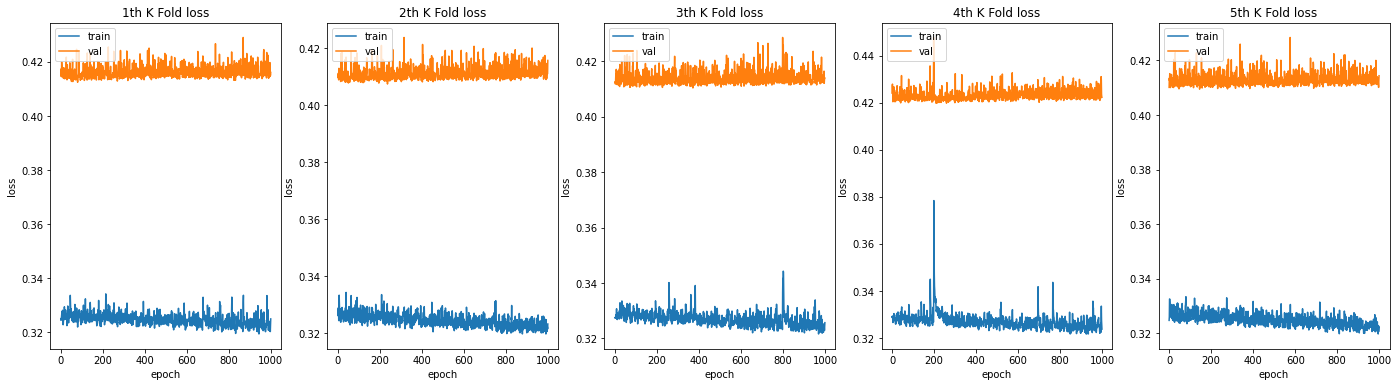

In [ ]:
f,ax=plt.subplots(1, 5,figsize=(24, 6))

for i in range(5):
    ax[i].set_title(str(i+1) + 'th K Fold loss')
    ax[i].plot(history[str(i+1)].history['loss'])
    ax[i].plot(history[str(i+1)].history['val_loss'])
    ax[i].set_ylabel('loss')
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'val'], loc='upper left')


plt.show()

### stacking train

In [ ]:
X_stack_train = stack_one_step(X_train) # (75450, 80, 6)

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 1000 (14001, 80)
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 2000 (28001, 80)
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 3000 (42001, 80)
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 4000 (56001, 80)
....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> 5000 (70001, 80)
....'....> ....'....> ....'....> ....'....(75450, 80)
(75450, 80)
(75450, 80)
(75450, 80)
(75450, 80)
(75450, 80)
(75450, 80, 6)


In [ ]:
history = training_stacking(X_stack_train, y_train, learning_rate_stacking, minibatch_size_stacking, num_epochs_stacking)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# drop out을 0으로
#train_costs_stacking, valid_costs_stacking =  training_stacking(X_stack_train, y_train, learning_rate_stacking, minibatch_size_stacking, num_epochs_stacking)

In [ ]:
plt.plot(train_costs_stacking)
plt.plot(valid_costs_stacking)
plt.title('Model Cost(Mean Absolute Error)')
plt.ylabel('cost(MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Prediction

In [ ]:
X_stack_test = stack_one_step(X_test) # (50300, 80, 6)

In [ ]:
Model_stacking = call_stackingModel_small(learning_rate_stacking)
prediction = Model_stacking.predict(X_stack_test)

In [ ]:
submission['pressure'] = prediction #_flat
submission.to_csv('/content/drive/MyDrive/Ventilator_Pressure_Prediction/submission_ver11.csv', index=False)

In [ ]:
submission

In [ ]:
prediction_flat = np.ravel(prediction)
prediction_flat.shape

In [ ]:
"""
Model_stack = call_stackingModel(learning_rate_stacking)

input_pred = tf.data.Dataset.from_tensor_slices((X_stack_test))
pred_minibatches = input_pred.batch(minibatch_size_stacking).prefetch(8)

prediction = np.zeros((1, 80))

i = 0
for minibatch_X in pred_minibatches:
    target_pred = np.zeros((minibatch_X.shape[0], 80, 1))
    #target_pred = np.ones((minibatch_X.shape[0], 80, 1))
    pred = Model_stack(minibatch_X, target_pred, training=False)
    prediction = np.concatenate((prediction, pred))

    i += 1
    if i % 100 == 0:
        print('>', end=' ')
        if i % 1000 == 0:
          print(i, prediction.shape)
    elif i % 50 == 0:
        print('\'', end='')
    elif i % 10 == 0:
        print(".", end='')

prediction = prediction[1:, :]

....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ....'....> ...